<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Welcome to Colaboratory!</h1>


Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

In [0]:
import os
import time
import numpy as np
import keras
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.layers import Dense,Reshape,BatchNormalization,LeakyReLU,Conv2DTranspose,Conv2D,Input,Flatten,ReLU,Lambda,Concatenate,UpSampling3D
from keras.models import Model, Sequential
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.initializers import RandomNormal
from keras.datasets.mnist import load_data
from keras.utils import plot_model
from skimage.transform import resize
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline
from tqdm import tqdm
import tensorflow.contrib as tc
import tensorflow.keras as tk
from keras import backend as K
import tensorflow as tf
from keras.layers import UpSampling2D,UpSampling3D,UpSampling1D,Flatten,ReLU,Dense, RepeatVector
import time


import pickle
from PIL import Image
import PIL
import random
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

try:
    from google.colab import files
except:
    print("Unable to import Google Colab")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## DataSet loading and preprocessing
#### Images are already pickled to avoid IO on colab



In [0]:
class TextDataset:
    def __init__(self, data_dir, split='train', imsize=64, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.imsize = imsize
        self.data = []
        self.data_dir = data_dir
        split_dir = os.path.join(data_dir, split)

        #self.filenames = self.load_filenames(split_dir)
        self.embeddings = self.load_embedding(split_dir)
        self.images=[]
        self.load_all_images()
        self.index=0
        
    def load_embedding(self, data_dir):
        embedding_filename = 'char-CNN-RNN-embeddings.pickle'
        #embedding_filename = '10kEmbedding.pickle'
        with open(os.path.join(data_dir, embedding_filename), 'rb') as f:
            embeddings = pickle.load(f,fix_imports=True, encoding='latin1')
            embeddings = np.array(embeddings)
            print('embeddings: ', embeddings.shape)
        return embeddings

    
    def reset(self):
        self.index=0

    def get_next_batch(self,batch=100,id=None):
        images, embeddings= [],[]
        if id is not None:
            self.index=id
        if len(self.embeddings)<=self.index+batch:
            self.index=0
            return images, embeddings
        images = self.images[self.index:min(self.index+batch,len(self.images))]    

        ids=np.random.randint(0, self.embeddings[0].shape[0]-1,min(self.index+batch,len(self.images)))
        for index in range(self.index, self.index+batch):        
            em = self.embeddings[index, ids[index], :]
            
            if self.target_transform is not None:
                em = self.target_transform(em)
            embeddings.append(em)
        self.index=min(self.index+batch,len(self.embeddings))
        return np.asarray(images), np.asarray(embeddings)
    


    def load_all_images(self):
        file = open(self.data_dir+'/all-images.pickle', 'rb')
        x=pickle.load(file)
        file.close()
        for im in x:
            self.images.append((im- 127.5) / 127.5)
        





In [36]:
dir = r"drive/My Drive/MS-data/flower"
dataset = TextDataset(dir,split="")

embeddings:  (7034, 10, 1024)


KL loss function

In [0]:
def kl_loss(a,b):
    def loss(y_true,y_pred):
        c_dim = 128
        x=y_pred
        mu = x[:, :c_dim]
        logvar = x[:,c_dim:]
        kld = - logvar + 0.5 * ( -1 + K.square(mu) + K.exp(2.0 * logvar) )
        return K.mean(kld)
    return loss(a,b)

def generate_c(x):
    c_dim = 128
    mean = x[:, :c_dim]
    log_sigma = x[:,c_dim:]
    # log_sigma = log_sigma * 0.5
    std = K.exp(log_sigma)
    eps = K.random_normal(K.shape(std))
    return (std*eps) + mean

Gan Model to creare low resolution images


In [0]:


class Phase1Gan:

    def __init__(self, dataset, kernel, strides, padding='same'):
        self.train_set = dataset
        self.kernel = kernel
        self.strides = strides
        self.padding = padding
        
        self.latent_dimension = 100
        self.initial_weight = RandomNormal(stddev=0.02)
        self.leaky_relu_slope = 0.2
        
        # Sequential model for generator & discremenator
        self.generator = None 
        self.discriminator = None 
        self.fids=[]
        self.generator_dim = 192 * 8
        self.embed_dim = 1024
        self.z_dim=100
        self.conditional_dim= 128
        self.disc_dim = 96
        self.fid = []
        self.generator_loss = []
        self.discriminator_loss = []

    def __create_CA(self,summary=False):
        """ Output c_code[1,128], mean_logsigma[1,256]
        """
        text_embedding = Input((1024,))
        t_dim = 1024
        c_dim = 128
        
        
        x = Dense(c_dim)(text_embedding)
        x = ReLU(0.2)(x)
        
        self.ca = Model(text_embedding,x)
        
        if summary:
            print(self.ca.summary())


    def __create_generator(self,summary=False):
        """
        Create Generator
        """
        
        input_noise = Input(shape=(100,))
        input_embed = Input(shape=(1024,))

        x = Dense(256)(input_embed)
        mean_sigma = ReLU(0.2)(x)
        x = Lambda(generate_c)(mean_sigma)
        
        combined = Concatenate()([input_noise, x])

        gen = Dense(self.generator_dim*4*4,use_bias=False)(combined)
        gen = BatchNormalization()(gen)
        gen = ReLU()(gen)
        gen = Reshape((4,4,self.generator_dim))(gen)

        # upsampling 1
        #gen = UpSampling3D((0.5,2,2),interpolation="nearest")(gen)
        gen = UpSampling2D((2,2),data_format='channels_last')(gen)
        #768
        gen = Conv2D(self.generator_dim // 2, kernel_size=(3, 3),strides=(1, 1),padding=self.padding,data_format='channels_last',use_bias=False)(gen)
        gen = BatchNormalization()(gen)
        gen = ReLU()(gen)

        # upsampling 2
        gen = UpSampling2D((2,2),data_format='channels_last')(gen)
        #384
        gen = Conv2D(self.generator_dim // 4, kernel_size=(3, 3),strides=(1, 1),padding=self.padding,data_format='channels_last',use_bias=False)(gen)
        gen = BatchNormalization()(gen)
        gen = ReLU()(gen)

        # # upsampling 3
        #194
        gen = UpSampling2D((2,2),data_format='channels_last')(gen)
        gen = Conv2D(self.generator_dim // 8, kernel_size=(3, 3),strides=(1, 1),padding=self.padding,data_format='channels_last',use_bias=False)(gen)
        gen = BatchNormalization()(gen)
        gen = ReLU()(gen)


        gen = Conv2D(3, kernel_size=3, strides=(1,1),padding=self.padding,data_format='channels_last', activation='tanh', use_bias=False)(gen)
        
        self.generator = Model([input_noise,input_embed], [gen,mean_sigma])
        
        if summary:
            print(self.generator.summary())

    def __create_discriminator(self,summary=False):
        """
        Create Discriminator
        """
        
        self.discriminator = Sequential()
        
        input_img = Input(( 32, 32,3))
        
        
        disc = Conv2D(self.disc_dim, kernel_size=4,strides=(2, 2),padding=self.padding,data_format='channels_last',use_bias=False)(input_img)
        disc = LeakyReLU(0.2)(disc)
        
        disc = Conv2D(self.disc_dim*2, kernel_size=4,strides=(2, 2),padding=self.padding,data_format='channels_last',use_bias=False)(disc)
        disc = BatchNormalization()(disc)
        disc = LeakyReLU(0.2)(disc)
        
        disc = Conv2D(self.disc_dim*8, kernel_size=4,strides=(2, 2),padding=self.padding,data_format='channels_last',use_bias=False)(disc)
        disc = BatchNormalization()(disc)
        disc = LeakyReLU(0.2)(disc)
        

        #gcode
        
        input_mu = Input(( 4, 4, 128))
        mu=input_mu
        comb = Concatenate(axis=3)([disc,mu])

        comb = Conv2D(self.disc_dim*8, kernel_size=(3, 3),strides=(1, 1),padding=self.padding,data_format='channels_last',use_bias=False)(comb)
        comb = BatchNormalization()(comb)
        comb = LeakyReLU(0.2)(comb)
        comb = Flatten()(comb)
        
        comb = Dense(1,activation='sigmoid')(comb)
        
        self.discriminator = Model([input_img,input_mu], comb)
        
        if summary:
            print(self.discriminator.summary())

    def compile_gan(self,summary=False,lr=0.00022 ):
        """
         Build generator & discriminator
        """
        self.__create_CA(summary)
        self.__create_generator(summary)
        self.__create_discriminator(summary)
        self.lr=lr
        optimizer=keras.optimizers.Adam(lr, beta_1=0.5,beta_2=0.999)
        
        self.ca.compile(optimizer, loss="binary_crossentropy",metrics=['binary_accuracy'])
        self.generator.compile(optimizer, loss="binary_crossentropy", metrics=['binary_accuracy'])
        self.discriminator.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
        
        self.discriminator.trainable = False

        noise, embeding, mean = Input((100,)), Input((1024,)), Input(shape=(4, 4, 128))
        
        img,logsigma = self.generator([noise, embeding])
        discre_output = self.discriminator([img,mean])
        
        self.model = Model(inputs=[noise,embeding,mean], outputs=[discre_output,logsigma])
        self.model.compile(optimizer, loss=['binary_crossentropy',kl_loss],loss_weights=[1,2.0], metrics=['binary_accuracy'])
        
        if summary:
            print(self.model.summary())
        
    def update_lr(self, lr):
        optimizer=keras.optimizers.Adam(lr, beta_1=0.5,beta_2=0.999)
        self.generator.compile(optimizer, loss="binary_crossentropy", metrics=['binary_accuracy'])
        self.discriminator.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
        self.model.compile(optimizer, loss=['binary_crossentropy',kl_loss],loss_weights=[1,2.0], metrics=['binary_accuracy'])
    
    def load_models(self):
        dir = "drive/My Drive/main"
        json_file = open(dir+"/Sgenerator.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()

        self.generator = keras.models.model_from_json(loaded_model_json)
        self.generator.load_weights(dir+"/sgenerator.h5")

        json_file = open(dir+"/Sca.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.ca = keras.models.model_from_json(loaded_model_json)
        self.ca.load_weights(dir+"/Sca.h5")

        json_file = open(dir+"/Smodel.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = keras.models.model_from_json(loaded_model_json)
        self.model.load_weights(dir+"/Smodel.h5")

        json_file = open(dir+"/sdiscriminator.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.discriminator = keras.models.model_from_json(loaded_model_json)
        self.discriminator.load_weights(dir+"/sdiscriminator.h5")

    def save_model(self):
        """
        Save models
        """
        model_json = self.model.to_json()
        dir = "drive/My Drive/main"
        with open(dir+"/Smodel.json", "w") as json_file:
            json_file.write(model_json)
        
        self.model.save_weights(dir+"/Smodel.h5")
        print("Saved model to disk")

        model_json = self.ca.to_json()
        with open(dir+"/Sca.json", "w") as json_file:
            json_file.write(model_json)
        
        self.ca.save_weights(dir+"/Sca.h5")
        print("Saved ca to disk")
        
        model_json = self.generator.to_json()
        with open(dir+"/Sgenerator.json", "w") as json_file:
            json_file.write(model_json)
        
        self.generator.save_weights(dir+"/sgenerator.h5")
        print("Saved model to disk")

        
        model_json = self.discriminator.to_json()
        with open(dir+"/sdiscriminator.json", "w") as json_file:
            json_file.write(model_json)
        
        self.discriminator.save_weights(dir+"/sdiscriminator.h5")
        print("Saved model to disk")

    def calculate_fid(self,result,expected):
        """
        Calculate FID
        """
        def scale_images(images, new_shape):
            """
            Scale Images
            """
            images_list = list()
            for image in images:
              new_image = resize(image, new_shape, 0)
              images_list.append(new_image)
            return asarray(images_list)

        inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
        
        set1 = result
        set2 = expected
        
        set1 = preprocess_input(scale_images(set1, (75,75,3)))
        set2 = preprocess_input(scale_images(set2, (75,75,3)))
        
        act1 = inception.predict(set1)
        act2 = inception.predict(set2)
        
        mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
        
        covmean = sqrtm(sigma1.dot(sigma2))
        if iscomplexobj(covmean):
          covmean = covmean.real
        
        return np.sum((mu1 - mu2)**2.0) + trace(sigma1 + sigma2 - 2.0 * covmean)

    def train(self, epochs, batch_size,save=False):
        """
        Train discriminator,generator and model
        """
        
        batch_size = batch_size
        
        fake_samples = np.zeros(shape=(batch_size, 1))
        real_samples = np.ones(shape=(batch_size, 1))*0.9999
        wrong_samples = fake_samples[1:]
        one_mean_var = np.ones(shape=(batch_size, 1, 256))

        for epoch in tqdm(range(epochs), total=epochs):
            disc_batch_loss = None
            gen_batch_losses = None
            self.train_set.reset()
            for batch in range(len(self.train_set.embeddings) //batch_size ):                
                self.discriminator.trainable = True
                real_imgs, encode_batch = self.train_set.get_next_batch(batch_size)
                # real_imgs = (real_imgs - 127.5) / 127.5
                # Generate mu_log
                mean =self.ca.predict_on_batch(encode_batch)
                mean = np.reshape(mean, (-1, 1, 1, 128))
                mean = np.tile(mean, (1, 4, 4, 1))
                
                # Generate Fake samples By Gen
                random_noise = np.random.normal(loc=0, scale=1.0, size=(batch_size, self.latent_dimension)) 
                random_input = [random_noise, encode_batch]
                fake_images,_ = self.generator.predict_on_batch(random_input)
                
                # Real samples 
                input_batch = [real_imgs, mean]
                discriminator_loss_real = self.discriminator.train_on_batch(x=input_batch, y=real_samples)

                input_batch = [fake_images, mean]
                discriminator_loss_fake = self.discriminator.train_on_batch(x=input_batch, y=fake_samples)
                
                # input_batch = [real_imgs[1:], mean[:-1]]
                # discriminator_loss_fake += self.discriminator.train_on_batch(x=input_batch, y=wrong_samples)

                # Discriminator Loss
                disc_batch_loss=0.5 * (discriminator_loss_real[0] + discriminator_loss_fake[0]*0.5)

                # Disable discriminator training and Train Generator weights
                self.discriminator.trainable = False
                gen_batch_losses=self.model.train_on_batch(x=[random_noise,encode_batch,mean], y=[real_samples,one_mean_var])
                

            self.discriminator_loss.append(disc_batch_loss)
            self.generator_loss.append(gen_batch_losses[0])

            print(time.asctime( time.localtime(time.time()) ),"discriminator_loss=",self.discriminator_loss[-1],"generator_losss", self.generator_loss[-1])

            if (epoch) % 3 == 0:
                if (epoch+1) % 10==0:
                    self.save_model()
                samples = 64
                base = np.random.randint(0,len(gan.train_set.embeddings)-samples)
                noise = np.random.normal(loc=0, scale=1, size=(samples, 100))
                embeddings = np.asarray([i[0] for i in gan.train_set.embeddings[base:base+samples]])
                #np.asarray([np.random.normal(loc=0, scale=1, size=(1, 100)) for _ in range(samples)])
                fake,_ = self.generator.predict_on_batch([noise,embeddings])
                expected = self.train_set.images[base:base+samples]
                fid = self.calculate_fid(fake,expected)
                # self.fid.append(fid)
                
                plt.clf()
                fig = plt.figure(figsize=(10,10))
                for i in range(samples):
                    sub = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
                    im = fake[i]
                    im = (im + 1.0) * 127.5
                    im = im.astype(np.uint8)
                    # Image.fromarray(np.asarray(im)).show()
                    plt.imshow(im)
                    # sub.imshow(((fake[i]+1)*127).astype(np.uint8))
                fig.tight_layout()
                plt.show()
                self.fid.append(fid)




  0%|          | 0/200 [00:00<?, ?it/s]

Training version 2: without CA in model



  0%|          | 1/200 [00:56<3:05:57, 56.07s/it]

Fri Nov 29 07:04:03 2019 discriminator_loss= 0.005395983578637242 generator_losss 0.10073897



  1%|          | 2/200 [01:41<2:54:30, 52.88s/it]

Fri Nov 29 07:04:48 2019 discriminator_loss= 0.07103291153907776 generator_losss 0.35672045



  2%|▏         | 3/200 [02:26<2:46:20, 50.66s/it]

Fri Nov 29 07:05:34 2019 discriminator_loss= 0.01674836315214634 generator_losss 0.039138705



  2%|▏         | 4/200 [03:12<2:40:15, 49.06s/it]

Fri Nov 29 07:06:19 2019 discriminator_loss= 0.00603803840931505 generator_losss 0.017311238



  2%|▎         | 5/200 [03:57<2:35:53, 47.97s/it]

Fri Nov 29 07:07:04 2019 discriminator_loss= 0.0022999848588369787 generator_losss 0.009494424



  3%|▎         | 6/200 [04:43<2:32:38, 47.21s/it]

Fri Nov 29 07:07:50 2019 discriminator_loss= 0.0008817345078568906 generator_losss 0.006244445



  4%|▎         | 7/200 [05:28<2:29:58, 46.63s/it]

Fri Nov 29 07:08:35 2019 discriminator_loss= 0.0009500584128545597 generator_losss 0.006475866



  4%|▍         | 8/200 [06:13<2:27:58, 46.24s/it]

Fri Nov 29 07:09:21 2019 discriminator_loss= 0.000772159401094541 generator_losss 0.004512415



  4%|▍         | 9/200 [06:59<2:26:23, 45.98s/it]

Fri Nov 29 07:10:06 2019 discriminator_loss= 0.0007210604162537493 generator_losss 0.0040487824
Fri Nov 29 07:10:51 2019 discriminator_loss= 0.0019363730098120868 generator_losss 0.0042737555
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

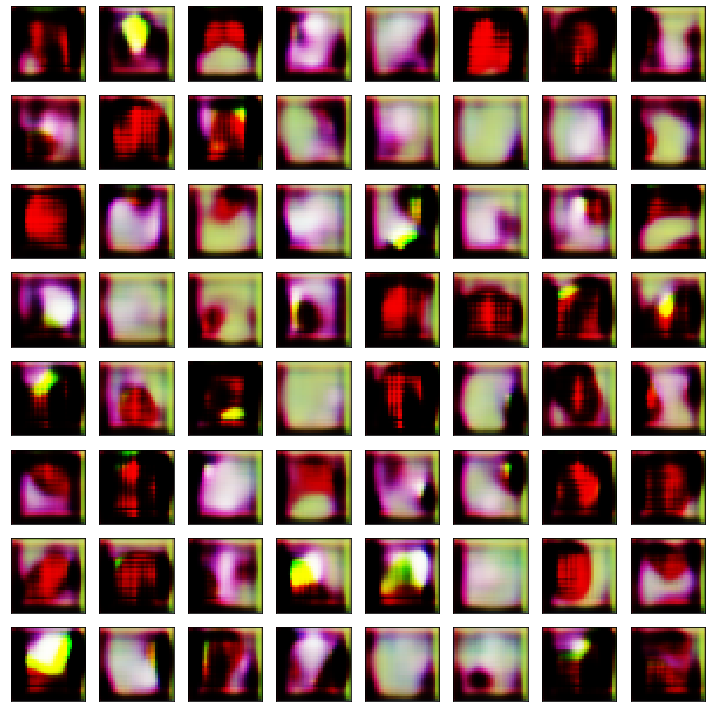


  6%|▌         | 11/200 [09:18<2:56:10, 55.93s/it]

Fri Nov 29 07:12:25 2019 discriminator_loss= 0.06002778670517728 generator_losss 1.1663507



  6%|▌         | 12/200 [10:04<2:45:29, 52.82s/it]

Fri Nov 29 07:13:11 2019 discriminator_loss= 0.2030818611383438 generator_losss 0.34244335



  6%|▋         | 13/200 [10:49<2:37:50, 50.64s/it]

Fri Nov 29 07:13:57 2019 discriminator_loss= 0.004250698373652995 generator_losss 0.013441915



  7%|▋         | 14/200 [11:35<2:32:18, 49.13s/it]

Fri Nov 29 07:14:42 2019 discriminator_loss= 0.0024968202924355865 generator_losss 0.013884336



  8%|▊         | 15/200 [12:20<2:28:08, 48.05s/it]

Fri Nov 29 07:15:28 2019 discriminator_loss= 0.0011993330845143646 generator_losss 0.0037532877



  8%|▊         | 16/200 [13:06<2:25:01, 47.29s/it]

Fri Nov 29 07:16:13 2019 discriminator_loss= 0.0010386284266132861 generator_losss 0.0038801292



  8%|▊         | 17/200 [13:52<2:22:37, 46.76s/it]

Fri Nov 29 07:16:59 2019 discriminator_loss= 0.0008956774545367807 generator_losss 0.0065753106



  9%|▉         | 18/200 [14:37<2:20:37, 46.36s/it]

Fri Nov 29 07:17:44 2019 discriminator_loss= 0.0007843533676350489 generator_losss 0.011057091



 10%|▉         | 19/200 [15:23<2:19:10, 46.13s/it]

Fri Nov 29 07:18:30 2019 discriminator_loss= 0.002664201514562592 generator_losss 0.00331673
Fri Nov 29 07:19:15 2019 discriminator_loss= 0.004755013505928218 generator_losss 0.018206393
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

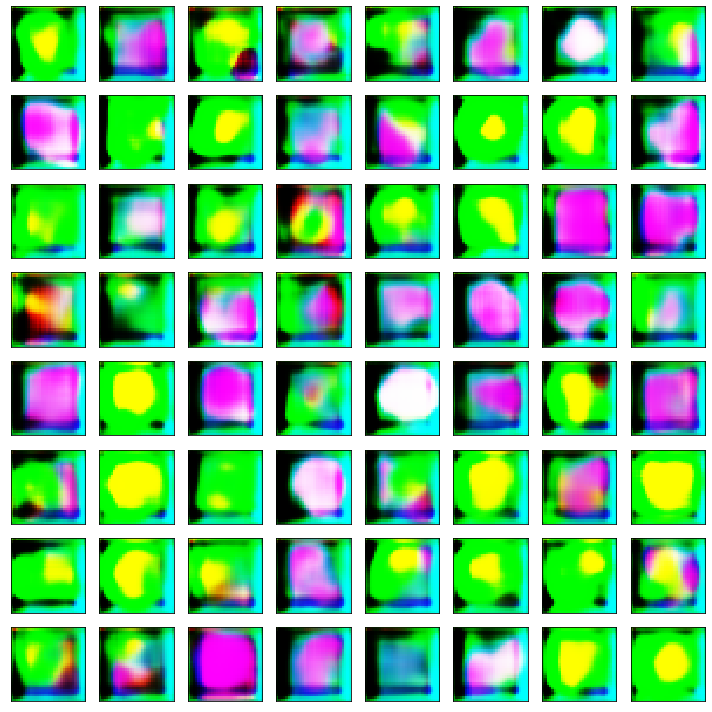


 10%|█         | 21/200 [17:37<2:43:47, 54.90s/it]

Fri Nov 29 07:20:44 2019 discriminator_loss= 0.011655012844130397 generator_losss 0.0074031306



 11%|█         | 22/200 [18:22<2:34:34, 52.10s/it]

Fri Nov 29 07:21:30 2019 discriminator_loss= 0.003929233644157648 generator_losss 0.011667512



 12%|█▏        | 23/200 [19:08<2:27:57, 50.16s/it]

Fri Nov 29 07:22:15 2019 discriminator_loss= 0.002358397876378149 generator_losss 0.021638662



 12%|█▏        | 24/200 [19:54<2:23:09, 48.80s/it]

Fri Nov 29 07:23:01 2019 discriminator_loss= 0.013702493160963058 generator_losss 0.005268924



 12%|█▎        | 25/200 [20:39<2:19:33, 47.85s/it]

Fri Nov 29 07:23:46 2019 discriminator_loss= 0.0020465184352360666 generator_losss 0.00912848



 13%|█▎        | 26/200 [21:25<2:16:45, 47.16s/it]

Fri Nov 29 07:24:32 2019 discriminator_loss= 0.007528417743742466 generator_losss 0.016904315



 14%|█▎        | 27/200 [22:10<2:14:31, 46.66s/it]

Fri Nov 29 07:25:17 2019 discriminator_loss= 0.015127317514270544 generator_losss 0.014290611



 14%|█▍        | 28/200 [22:56<2:12:48, 46.33s/it]

Fri Nov 29 07:26:03 2019 discriminator_loss= 0.004932463867589831 generator_losss 0.003768058



 14%|█▍        | 29/200 [23:41<2:11:22, 46.10s/it]

Fri Nov 29 07:26:49 2019 discriminator_loss= 0.0030410123290494084 generator_losss 0.03396542
Fri Nov 29 07:27:34 2019 discriminator_loss= 0.0018670032150112092 generator_losss 0.027886335
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

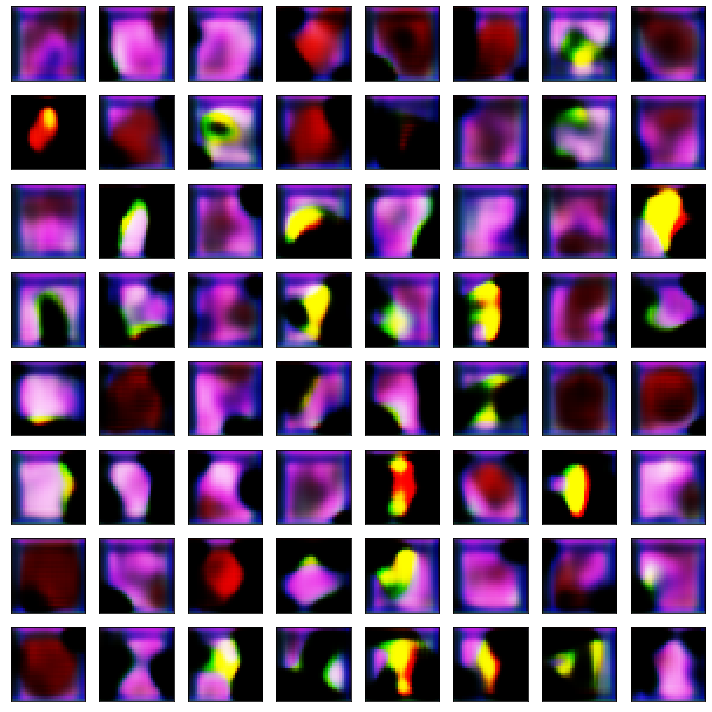


 16%|█▌        | 31/200 [25:59<2:36:57, 55.73s/it]

Fri Nov 29 07:29:07 2019 discriminator_loss= 0.0018755459459498525 generator_losss 0.011148321



 16%|█▌        | 32/200 [26:45<2:27:41, 52.75s/it]

Fri Nov 29 07:29:53 2019 discriminator_loss= 0.0011580134159885347 generator_losss 0.029459734



 16%|█▋        | 33/200 [27:31<2:21:06, 50.70s/it]

Fri Nov 29 07:30:38 2019 discriminator_loss= 0.003481948748230934 generator_losss 0.021564579



 17%|█▋        | 34/200 [28:17<2:16:14, 49.25s/it]

Fri Nov 29 07:31:24 2019 discriminator_loss= 0.029592646285891533 generator_losss 0.010326935



 18%|█▊        | 35/200 [29:03<2:12:31, 48.19s/it]

Fri Nov 29 07:32:10 2019 discriminator_loss= 0.0185700636357069 generator_losss 0.031789437



 18%|█▊        | 36/200 [29:48<2:09:35, 47.41s/it]

Fri Nov 29 07:32:56 2019 discriminator_loss= 0.0032513204496353865 generator_losss 0.0039818985



 18%|█▊        | 37/200 [30:34<2:07:28, 46.93s/it]

Fri Nov 29 07:33:41 2019 discriminator_loss= 0.011500251974212006 generator_losss 0.022377402



 19%|█▉        | 38/200 [31:20<2:05:48, 46.60s/it]

Fri Nov 29 07:34:27 2019 discriminator_loss= 0.004594915400957689 generator_losss 0.027526405



 20%|█▉        | 39/200 [32:06<2:04:26, 46.38s/it]

Fri Nov 29 07:35:13 2019 discriminator_loss= 0.001647505097935209 generator_losss 0.0038738884
Fri Nov 29 07:35:59 2019 discriminator_loss= 0.3236200213432312 generator_losss 1.8005592
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

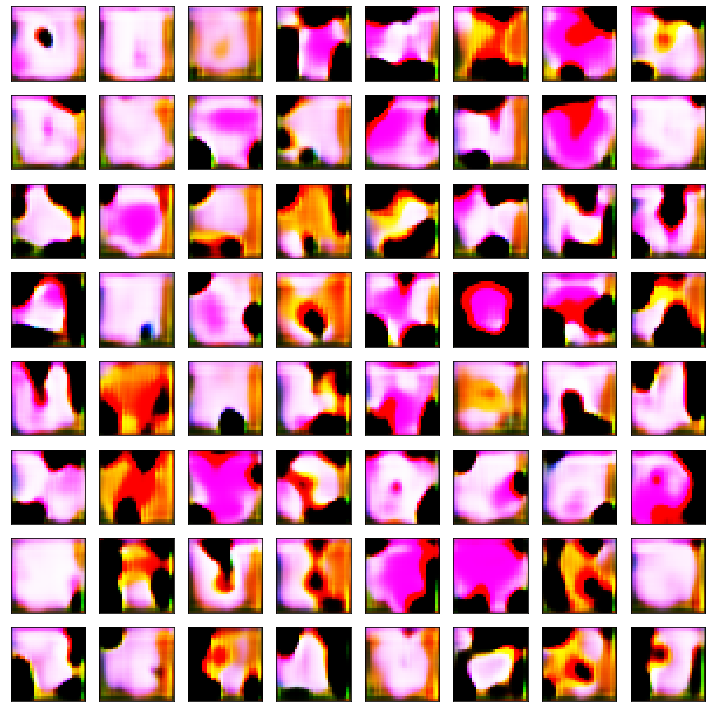


 20%|██        | 41/200 [34:27<2:29:33, 56.43s/it]

Fri Nov 29 07:37:34 2019 discriminator_loss= 0.04180764965713024 generator_losss 0.08728094



 21%|██        | 42/200 [35:13<2:20:19, 53.29s/it]

Fri Nov 29 07:38:20 2019 discriminator_loss= 0.019406830077059567 generator_losss 0.14190736



 22%|██▏       | 43/200 [35:58<2:13:32, 51.03s/it]

Fri Nov 29 07:39:06 2019 discriminator_loss= 0.007494775811210275 generator_losss 0.013746534



 22%|██▏       | 44/200 [36:44<2:08:38, 49.48s/it]

Fri Nov 29 07:39:51 2019 discriminator_loss= 0.014294371008872986 generator_losss 0.04704359



 22%|██▎       | 45/200 [37:30<2:05:06, 48.43s/it]

Fri Nov 29 07:40:37 2019 discriminator_loss= 0.003983114846050739 generator_losss 0.04520451



 23%|██▎       | 46/200 [38:16<2:02:24, 47.69s/it]

Fri Nov 29 07:41:23 2019 discriminator_loss= 0.02642126940190792 generator_losss 0.26189306



 24%|██▎       | 47/200 [39:02<2:00:09, 47.12s/it]

Fri Nov 29 07:42:09 2019 discriminator_loss= 0.03058282984420657 generator_losss 0.48273993



 24%|██▍       | 48/200 [39:48<1:58:16, 46.69s/it]

Fri Nov 29 07:42:55 2019 discriminator_loss= 0.002759308321401477 generator_losss 0.02322361



 24%|██▍       | 49/200 [40:33<1:56:47, 46.41s/it]

Fri Nov 29 07:43:41 2019 discriminator_loss= 0.0019797798013314605 generator_losss 0.018048739
Fri Nov 29 07:44:27 2019 discriminator_loss= 0.08363621437456459 generator_losss 0.95215666
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

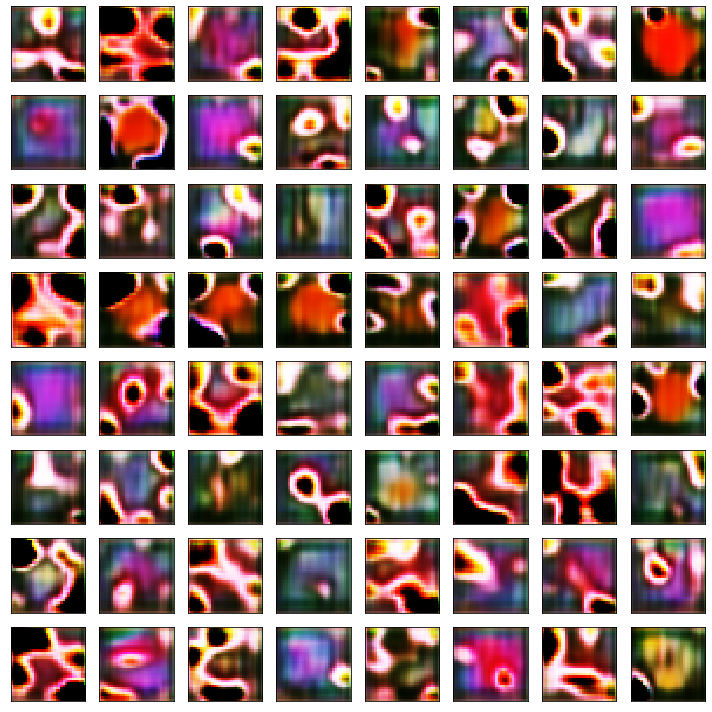


 26%|██▌       | 51/200 [42:56<2:21:01, 56.79s/it]

Fri Nov 29 07:46:03 2019 discriminator_loss= 0.3184403093182482 generator_losss 0.90310794



 26%|██▌       | 52/200 [43:42<2:12:05, 53.55s/it]

Fri Nov 29 07:46:49 2019 discriminator_loss= 0.8047163859009743 generator_losss 1.7488508



 26%|██▋       | 53/200 [44:28<2:05:36, 51.27s/it]

Fri Nov 29 07:47:35 2019 discriminator_loss= 0.005329167935997248 generator_losss 0.021872811



 27%|██▋       | 54/200 [45:14<2:00:53, 49.68s/it]

Fri Nov 29 07:48:21 2019 discriminator_loss= 0.0009251827432308346 generator_losss 0.0039427867



 28%|██▊       | 55/200 [46:00<1:57:19, 48.55s/it]

Fri Nov 29 07:49:07 2019 discriminator_loss= 0.002355327713303268 generator_losss 0.025298214



 28%|██▊       | 56/200 [46:45<1:54:30, 47.72s/it]

Fri Nov 29 07:49:53 2019 discriminator_loss= 0.001756876881700009 generator_losss 0.009686586



 28%|██▊       | 57/200 [47:31<1:52:23, 47.16s/it]

Fri Nov 29 07:50:38 2019 discriminator_loss= 0.00249477504985407 generator_losss 0.009846672



 29%|██▉       | 58/200 [48:17<1:50:44, 46.79s/it]

Fri Nov 29 07:51:24 2019 discriminator_loss= 0.00781763531267643 generator_losss 0.120391995



 30%|██▉       | 59/200 [49:03<1:49:24, 46.55s/it]

Fri Nov 29 07:52:10 2019 discriminator_loss= 0.0026601326535455883 generator_losss 0.005363431
Fri Nov 29 07:52:56 2019 discriminator_loss= 0.004343231114035007 generator_losss 0.005567005
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

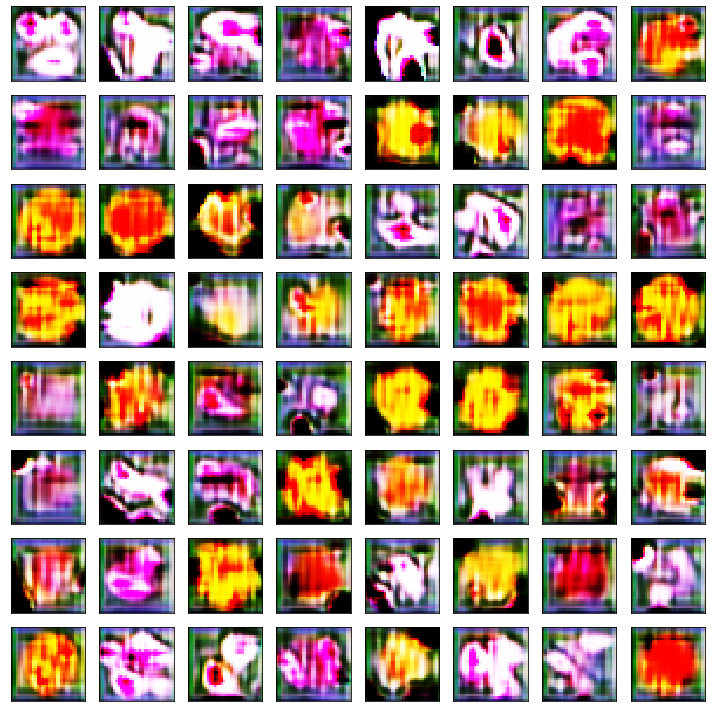


 30%|███       | 61/200 [51:29<2:13:26, 57.60s/it]

Fri Nov 29 07:54:36 2019 discriminator_loss= 0.0034948698594234884 generator_losss 0.007968981



 31%|███       | 62/200 [52:15<2:04:31, 54.14s/it]

Fri Nov 29 07:55:22 2019 discriminator_loss= 0.9370673596858978 generator_losss 2.1228356



 32%|███▏      | 63/200 [53:01<1:57:58, 51.67s/it]

Fri Nov 29 07:56:08 2019 discriminator_loss= 0.006550776888616383 generator_losss 0.054442983



 32%|███▏      | 64/200 [53:47<1:53:18, 49.99s/it]

Fri Nov 29 07:56:54 2019 discriminator_loss= 0.0016492410795763135 generator_losss 0.005997337



 32%|███▎      | 65/200 [54:33<1:49:51, 48.82s/it]

Fri Nov 29 07:57:41 2019 discriminator_loss= 0.07078979816287756 generator_losss 0.0029728615



 33%|███▎      | 66/200 [55:19<1:47:13, 48.01s/it]

Fri Nov 29 07:58:27 2019 discriminator_loss= 0.005884303478524089 generator_losss 0.0076522846



 34%|███▎      | 67/200 [56:05<1:45:05, 47.41s/it]

Fri Nov 29 07:59:13 2019 discriminator_loss= 0.0023222234449349344 generator_losss 0.012410115



 34%|███▍      | 68/200 [56:52<1:43:27, 47.03s/it]

Fri Nov 29 07:59:59 2019 discriminator_loss= 0.001124860078562051 generator_losss 0.011126646



 34%|███▍      | 69/200 [57:37<1:41:56, 46.69s/it]

Fri Nov 29 08:00:45 2019 discriminator_loss= 0.12034280408988707 generator_losss 0.05545252
Fri Nov 29 08:01:31 2019 discriminator_loss= 0.5126752033829689 generator_losss 0.46173528
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

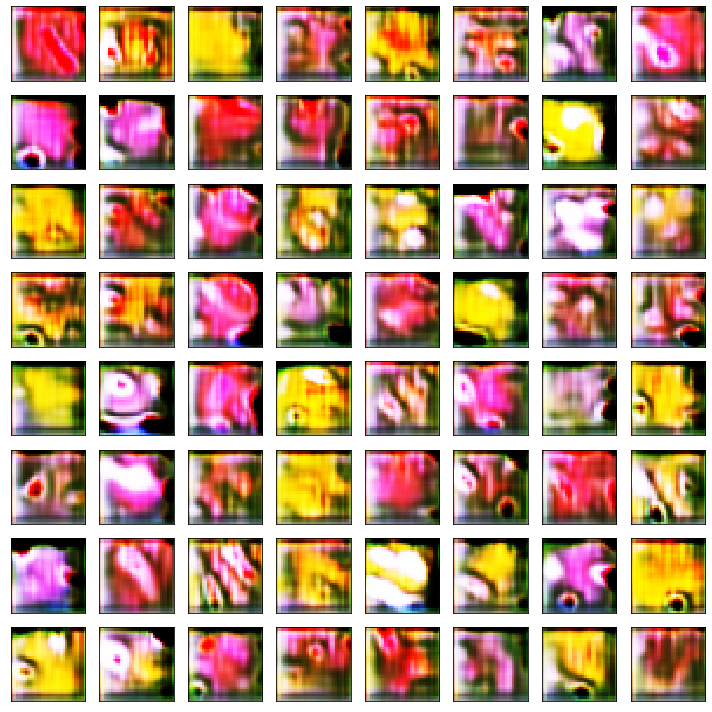


 36%|███▌      | 71/200 [1:00:07<2:05:38, 58.44s/it]

Fri Nov 29 08:03:14 2019 discriminator_loss= 0.050830332562327385 generator_losss 0.09429657



 36%|███▌      | 72/200 [1:00:53<1:56:53, 54.79s/it]

Fri Nov 29 08:04:00 2019 discriminator_loss= 0.006295186234638095 generator_losss 0.011781602



 36%|███▋      | 73/200 [1:01:39<1:50:26, 52.18s/it]

Fri Nov 29 08:04:46 2019 discriminator_loss= 0.002428470237646252 generator_losss 0.0039107623



 37%|███▋      | 74/200 [1:02:25<1:45:43, 50.35s/it]

Fri Nov 29 08:05:33 2019 discriminator_loss= 0.009727695025503635 generator_losss 0.12881868



 38%|███▊      | 75/200 [1:03:12<1:42:25, 49.16s/it]

Fri Nov 29 08:06:19 2019 discriminator_loss= 0.006323036039248109 generator_losss 0.01109077



 38%|███▊      | 76/200 [1:03:58<1:39:44, 48.26s/it]

Fri Nov 29 08:07:05 2019 discriminator_loss= 0.01644803793169558 generator_losss 0.014083168



 38%|███▊      | 77/200 [1:04:44<1:37:39, 47.64s/it]

Fri Nov 29 08:07:51 2019 discriminator_loss= 0.664658684283495 generator_losss 0.99518436



 39%|███▉      | 78/200 [1:05:30<1:36:01, 47.23s/it]

Fri Nov 29 08:08:38 2019 discriminator_loss= 0.009264713851734996 generator_losss 0.017980887



 40%|███▉      | 79/200 [1:06:17<1:34:39, 46.94s/it]

Fri Nov 29 08:09:24 2019 discriminator_loss= 0.026815306395292282 generator_losss 0.05036409
Fri Nov 29 08:10:10 2019 discriminator_loss= 0.11925111338496208 generator_losss 1.5172036
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

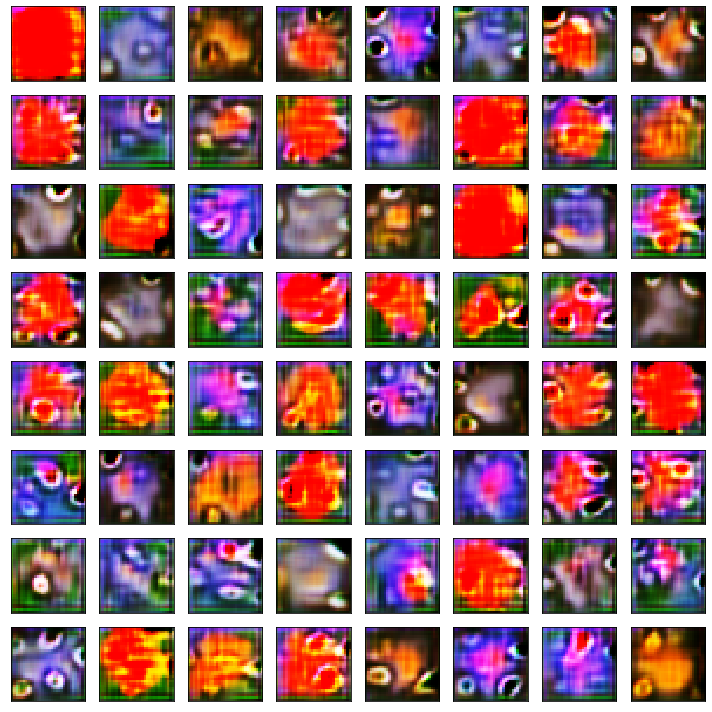


 40%|████      | 81/200 [1:08:48<1:57:04, 59.03s/it]

Fri Nov 29 08:11:55 2019 discriminator_loss= 0.008255642605945468 generator_losss 0.09849875



 41%|████      | 82/200 [1:09:35<1:48:45, 55.30s/it]

Fri Nov 29 08:12:42 2019 discriminator_loss= 0.0089629627764225 generator_losss 0.03899615



 42%|████▏     | 83/200 [1:10:21<1:42:51, 52.74s/it]

Fri Nov 29 08:13:29 2019 discriminator_loss= 0.004923770437017083 generator_losss 0.006602616



 42%|████▏     | 84/200 [1:11:08<1:38:26, 50.92s/it]

Fri Nov 29 08:14:15 2019 discriminator_loss= 0.006465293699875474 generator_losss 0.04234591



 42%|████▎     | 85/200 [1:11:55<1:35:11, 49.66s/it]

Fri Nov 29 08:15:02 2019 discriminator_loss= 0.0017483941046521068 generator_losss 0.0051710894



 43%|████▎     | 86/200 [1:12:41<1:32:39, 48.77s/it]

Fri Nov 29 08:15:49 2019 discriminator_loss= 0.0026386642712168396 generator_losss 0.0059752585



 44%|████▎     | 87/200 [1:13:28<1:30:41, 48.15s/it]

Fri Nov 29 08:16:35 2019 discriminator_loss= 0.1888483688235283 generator_losss 6.042133



 44%|████▍     | 88/200 [1:14:15<1:29:00, 47.68s/it]

Fri Nov 29 08:17:22 2019 discriminator_loss= 0.00757501064799726 generator_losss 0.027777772



 44%|████▍     | 89/200 [1:15:01<1:27:38, 47.38s/it]

Fri Nov 29 08:18:09 2019 discriminator_loss= 0.03118958417326212 generator_losss 3.1527758
Fri Nov 29 08:18:55 2019 discriminator_loss= 0.0019141650409437716 generator_losss 0.07364266
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

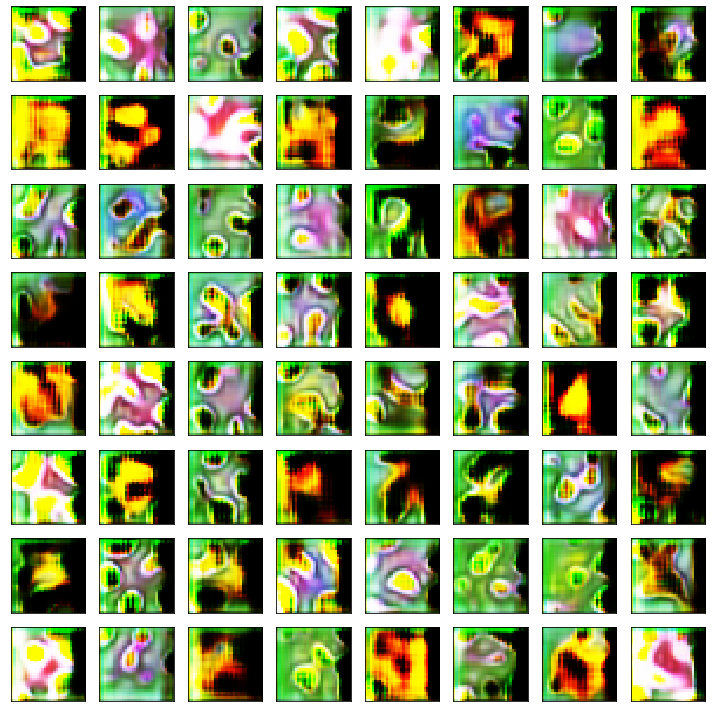


 46%|████▌     | 91/200 [1:17:38<1:49:34, 60.32s/it]

Fri Nov 29 08:20:45 2019 discriminator_loss= 0.005241637001745403 generator_losss 0.11476095



 46%|████▌     | 92/200 [1:18:25<1:41:19, 56.29s/it]

Fri Nov 29 08:21:32 2019 discriminator_loss= 0.0037350566126406193 generator_losss 0.02184828



 46%|████▋     | 93/200 [1:19:12<1:35:17, 53.44s/it]

Fri Nov 29 08:22:19 2019 discriminator_loss= 0.003383361412488739 generator_losss 0.02203984



 47%|████▋     | 94/200 [1:19:58<1:30:54, 51.46s/it]

Fri Nov 29 08:23:06 2019 discriminator_loss= 0.010971928364597261 generator_losss 0.027568672



 48%|████▊     | 95/200 [1:20:45<1:27:34, 50.04s/it]

Fri Nov 29 08:23:52 2019 discriminator_loss= 0.0017390395805705339 generator_losss 0.015575689



 48%|████▊     | 96/200 [1:21:32<1:25:02, 49.06s/it]

Fri Nov 29 08:24:39 2019 discriminator_loss= 0.007343432400375605 generator_losss 0.54755324



 48%|████▊     | 97/200 [1:22:19<1:23:02, 48.37s/it]

Fri Nov 29 08:25:26 2019 discriminator_loss= 0.0100899210665375 generator_losss 0.1686662



 49%|████▉     | 98/200 [1:23:06<1:21:30, 47.94s/it]

Fri Nov 29 08:26:13 2019 discriminator_loss= 0.04326478054281324 generator_losss 0.029109456



 50%|████▉     | 99/200 [1:23:52<1:20:05, 47.58s/it]

Fri Nov 29 08:27:00 2019 discriminator_loss= 0.0016683497815392911 generator_losss 0.093991645
Fri Nov 29 08:27:46 2019 discriminator_loss= 0.008348600938916206 generator_losss 0.033051174
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

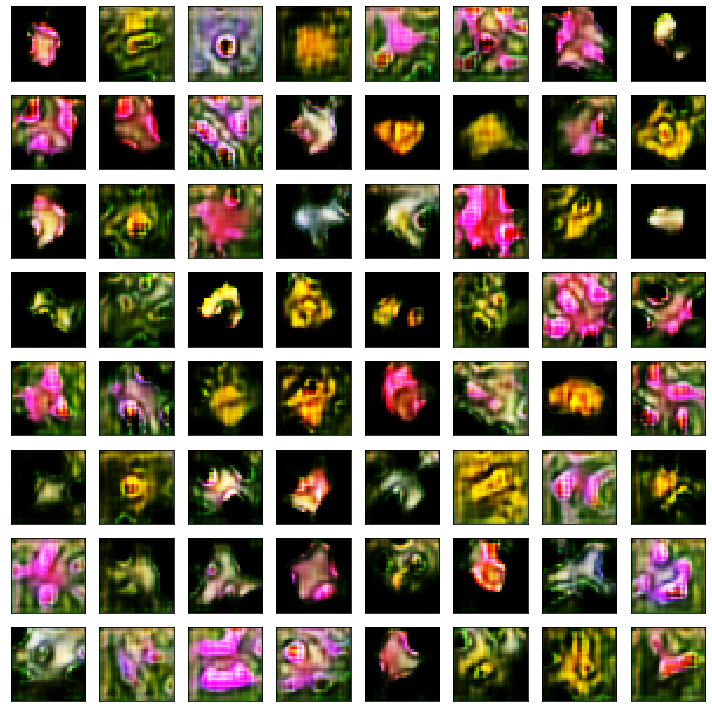


 50%|█████     | 101/200 [1:26:29<1:39:35, 60.36s/it]

Fri Nov 29 08:29:36 2019 discriminator_loss= 0.07067759335041046 generator_losss 0.30909267



 51%|█████     | 102/200 [1:27:15<1:31:58, 56.31s/it]

Fri Nov 29 08:30:23 2019 discriminator_loss= 0.007818151032552123 generator_losss 0.014656396



 52%|█████▏    | 103/200 [1:28:02<1:26:30, 53.51s/it]

Fri Nov 29 08:31:10 2019 discriminator_loss= 2.136723965406418 generator_losss 4.6107006



 52%|█████▏    | 104/200 [1:28:49<1:22:27, 51.53s/it]

Fri Nov 29 08:31:57 2019 discriminator_loss= 0.0017954421637114137 generator_losss 0.11100885



 52%|█████▎    | 105/200 [1:29:36<1:19:25, 50.16s/it]

Fri Nov 29 08:32:44 2019 discriminator_loss= 0.026476765051484108 generator_losss 0.27455765



 53%|█████▎    | 106/200 [1:30:23<1:17:04, 49.19s/it]

Fri Nov 29 08:33:31 2019 discriminator_loss= 0.15945907635614276 generator_losss 4.021991



 54%|█████▎    | 107/200 [1:31:10<1:15:16, 48.56s/it]

Fri Nov 29 08:34:18 2019 discriminator_loss= 0.1719422847381793 generator_losss 2.0463367



 54%|█████▍    | 108/200 [1:31:57<1:13:42, 48.07s/it]

Fri Nov 29 08:35:05 2019 discriminator_loss= 0.008170082233846188 generator_losss 0.119133934



 55%|█████▍    | 109/200 [1:32:44<1:12:25, 47.75s/it]

Fri Nov 29 08:35:52 2019 discriminator_loss= 0.007591094123199582 generator_losss 1.2649063
Fri Nov 29 08:36:38 2019 discriminator_loss= 0.0013560976658482105 generator_losss 0.031726632
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

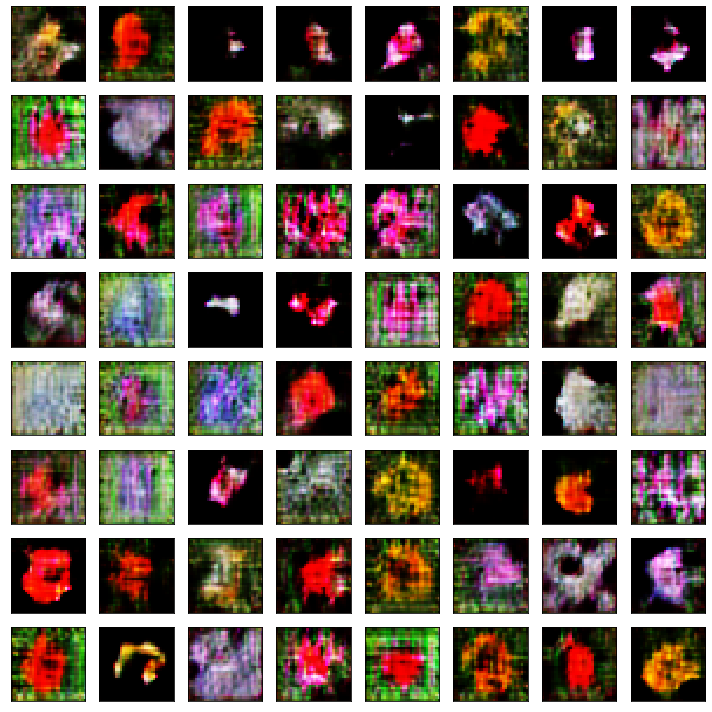


 56%|█████▌    | 111/200 [1:35:27<1:31:43, 61.84s/it]

Fri Nov 29 08:38:34 2019 discriminator_loss= 0.020975415827706456 generator_losss 2.1864495



 56%|█████▌    | 112/200 [1:36:14<1:24:13, 57.42s/it]

Fri Nov 29 08:39:21 2019 discriminator_loss= 0.005005743587389588 generator_losss 0.23897322



 56%|█████▋    | 113/200 [1:37:01<1:18:46, 54.33s/it]

Fri Nov 29 08:40:08 2019 discriminator_loss= 0.008612553065177053 generator_losss 1.6878694



 57%|█████▋    | 114/200 [1:37:48<1:14:43, 52.14s/it]

Fri Nov 29 08:40:55 2019 discriminator_loss= 0.0039992973615881056 generator_losss 2.6069076



 57%|█████▊    | 115/200 [1:38:35<1:11:43, 50.63s/it]

Fri Nov 29 08:41:43 2019 discriminator_loss= 0.0012948430085089058 generator_losss 2.607886



 58%|█████▊    | 116/200 [1:39:22<1:09:22, 49.56s/it]

Fri Nov 29 08:42:30 2019 discriminator_loss= 0.004982034442946315 generator_losss 4.1933236



 58%|█████▊    | 117/200 [1:40:09<1:07:31, 48.81s/it]

Fri Nov 29 08:43:17 2019 discriminator_loss= 0.005897360329981893 generator_losss 5.949175



 59%|█████▉    | 118/200 [1:40:56<1:05:57, 48.27s/it]

Fri Nov 29 08:44:04 2019 discriminator_loss= 0.0020114388898946345 generator_losss 2.3759437



 60%|█████▉    | 119/200 [1:41:43<1:04:37, 47.87s/it]

Fri Nov 29 08:44:51 2019 discriminator_loss= 0.0015807425952516496 generator_losss 2.1528327
Fri Nov 29 08:45:38 2019 discriminator_loss= 0.0021563583723036572 generator_losss 7.2599063
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

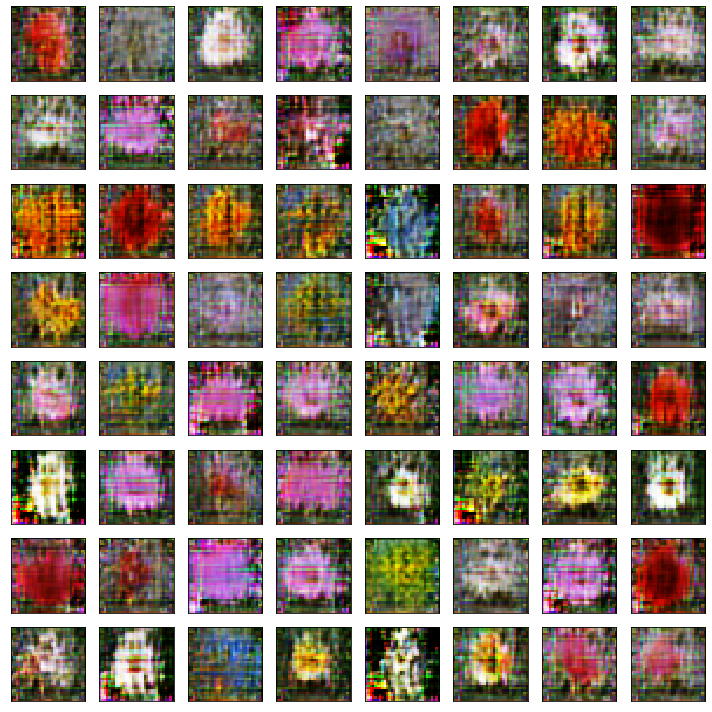


 60%|██████    | 121/200 [1:44:28<1:21:58, 62.25s/it]

Fri Nov 29 08:47:35 2019 discriminator_loss= 0.001699386484688148 generator_losss 4.7849536



 61%|██████    | 122/200 [1:45:15<1:15:05, 57.76s/it]

Fri Nov 29 08:48:22 2019 discriminator_loss= 0.0015172745333984494 generator_losss 2.9533737



 62%|██████▏   | 123/200 [1:46:02<1:10:06, 54.63s/it]

Fri Nov 29 08:49:10 2019 discriminator_loss= 0.0017919756210176274 generator_losss 6.5296345



 62%|██████▏   | 124/200 [1:46:50<1:06:21, 52.38s/it]

Fri Nov 29 08:49:57 2019 discriminator_loss= 0.0013839244493283331 generator_losss 7.6973343



 62%|██████▎   | 125/200 [1:47:37<1:03:32, 50.84s/it]

Fri Nov 29 08:50:44 2019 discriminator_loss= 0.0018320030358154327 generator_losss 6.630974



 63%|██████▎   | 126/200 [1:48:24<1:01:24, 49.80s/it]

Fri Nov 29 08:51:31 2019 discriminator_loss= 0.0007847682063584216 generator_losss 5.4863653



 64%|██████▎   | 127/200 [1:49:11<59:39, 49.03s/it]  

Fri Nov 29 08:52:19 2019 discriminator_loss= 0.0007440975750796497 generator_losss 4.249401



 64%|██████▍   | 128/200 [1:49:59<58:11, 48.49s/it]

Fri Nov 29 08:53:06 2019 discriminator_loss= 0.0008016963474801742 generator_losss 6.167001



 64%|██████▍   | 129/200 [1:50:46<56:59, 48.17s/it]

Fri Nov 29 08:53:53 2019 discriminator_loss= 0.0005894250571145676 generator_losss 6.178668
Fri Nov 29 08:54:41 2019 discriminator_loss= 0.0020796750904992223 generator_losss 9.260808
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

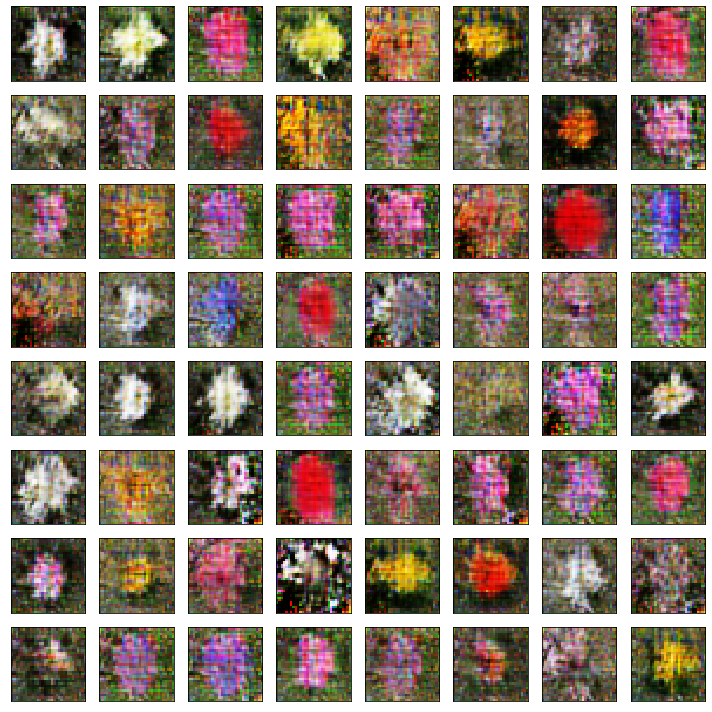


 66%|██████▌   | 131/200 [1:53:33<1:12:29, 63.04s/it]

Fri Nov 29 08:56:41 2019 discriminator_loss= 0.0023347235401161015 generator_losss 7.358586



 66%|██████▌   | 132/200 [1:54:21<1:06:08, 58.37s/it]

Fri Nov 29 08:57:28 2019 discriminator_loss= 0.0010863577845157124 generator_losss 6.175374



 66%|██████▋   | 133/200 [1:55:08<1:01:35, 55.15s/it]

Fri Nov 29 08:58:16 2019 discriminator_loss= 0.0024648663820698857 generator_losss 6.137364



 67%|██████▋   | 134/200 [1:55:56<58:10, 52.89s/it]  

Fri Nov 29 08:59:03 2019 discriminator_loss= 0.0005958068140898831 generator_losss 7.7528462



 68%|██████▊   | 135/200 [1:56:44<55:38, 51.35s/it]

Fri Nov 29 08:59:51 2019 discriminator_loss= 0.0007124493859009817 generator_losss 8.125192



 68%|██████▊   | 136/200 [1:57:31<53:33, 50.21s/it]

Fri Nov 29 09:00:39 2019 discriminator_loss= 0.10405920166522264 generator_losss 2.7343004



 68%|██████▊   | 137/200 [1:58:19<51:53, 49.42s/it]

Fri Nov 29 09:01:26 2019 discriminator_loss= 0.011370934778824449 generator_losss 0.9838462



 69%|██████▉   | 138/200 [1:59:06<50:26, 48.82s/it]

Fri Nov 29 09:02:14 2019 discriminator_loss= 0.001019872899632901 generator_losss 0.5604751



 70%|██████▉   | 139/200 [1:59:54<49:14, 48.43s/it]

Fri Nov 29 09:03:01 2019 discriminator_loss= 0.002228157944045961 generator_losss 5.8899794
Fri Nov 29 09:03:49 2019 discriminator_loss= 0.0009210657372022979 generator_losss 4.0625734
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

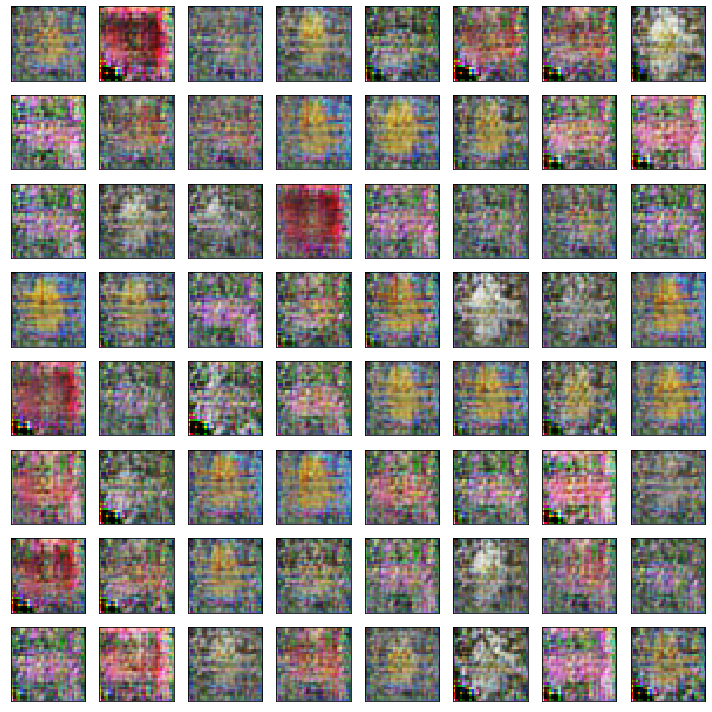


 70%|███████   | 141/200 [2:02:46<1:03:10, 64.25s/it]

Fri Nov 29 09:05:54 2019 discriminator_loss= 0.0010145802621082112 generator_losss 6.33759



 71%|███████   | 142/200 [2:03:34<57:22, 59.36s/it]  

Fri Nov 29 09:06:41 2019 discriminator_loss= 0.0006794872606405988 generator_losss 4.65194



 72%|███████▏  | 143/200 [2:04:22<53:06, 55.90s/it]

Fri Nov 29 09:07:29 2019 discriminator_loss= 0.0006445057588280179 generator_losss 7.9765487



 72%|███████▏  | 144/200 [2:05:10<49:57, 53.53s/it]

Fri Nov 29 09:08:17 2019 discriminator_loss= 0.0010520050418563187 generator_losss 7.56613



 72%|███████▎  | 145/200 [2:05:58<47:27, 51.78s/it]

Fri Nov 29 09:09:05 2019 discriminator_loss= 0.001551927882246673 generator_losss 4.0449233



 73%|███████▎  | 146/200 [2:06:45<45:29, 50.55s/it]

Fri Nov 29 09:09:53 2019 discriminator_loss= 0.0005411533402366331 generator_losss 6.462289



 74%|███████▎  | 147/200 [2:07:33<43:52, 49.67s/it]

Fri Nov 29 09:10:40 2019 discriminator_loss= 0.000620660801359918 generator_losss 7.7019715



 74%|███████▍  | 148/200 [2:08:21<42:31, 49.07s/it]

Fri Nov 29 09:11:28 2019 discriminator_loss= 0.003005265141837299 generator_losss 8.202663



 74%|███████▍  | 149/200 [2:09:08<41:19, 48.62s/it]

Fri Nov 29 09:12:16 2019 discriminator_loss= 0.000562466864266753 generator_losss 6.497612
Fri Nov 29 09:13:03 2019 discriminator_loss= 0.0005699886532966048 generator_losss 10.838933
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

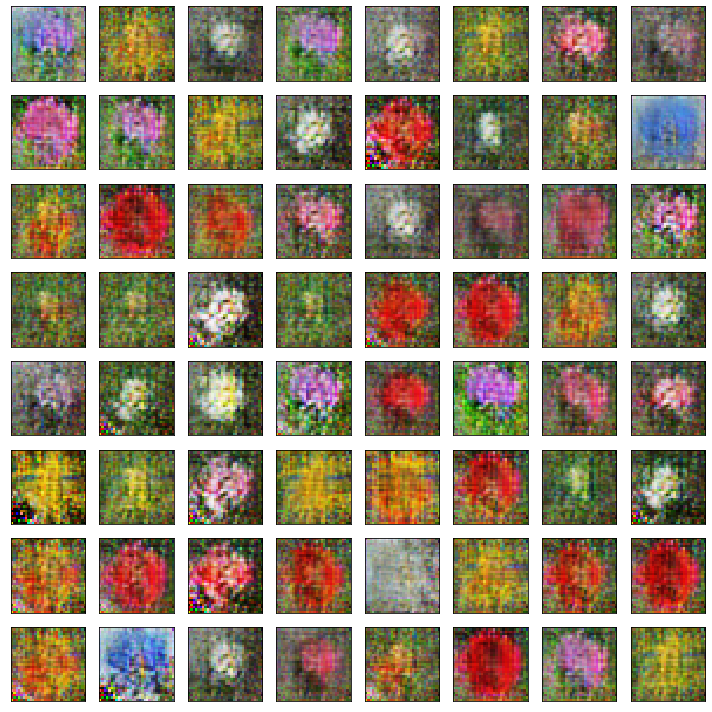


 76%|███████▌  | 151/200 [2:12:00<52:30, 64.29s/it]

Fri Nov 29 09:15:08 2019 discriminator_loss= 0.004085748107172549 generator_losss 2.1687963



 76%|███████▌  | 152/200 [2:12:48<47:29, 59.36s/it]

Fri Nov 29 09:15:56 2019 discriminator_loss= 0.0005741874992963858 generator_losss 2.9610944



 76%|███████▋  | 153/200 [2:13:36<43:46, 55.89s/it]

Fri Nov 29 09:16:43 2019 discriminator_loss= 0.000789990444900468 generator_losss 6.7770786



 77%|███████▋  | 154/200 [2:14:24<40:57, 53.43s/it]

Fri Nov 29 09:17:31 2019 discriminator_loss= 0.0009394621883984655 generator_losss 4.9639454



 78%|███████▊  | 155/200 [2:15:12<38:48, 51.74s/it]

Fri Nov 29 09:18:19 2019 discriminator_loss= 0.0005568905144173186 generator_losss 6.2009816



 78%|███████▊  | 156/200 [2:15:59<37:03, 50.54s/it]

Fri Nov 29 09:19:07 2019 discriminator_loss= 0.0005978630651952699 generator_losss 8.224745



 78%|███████▊  | 157/200 [2:16:47<35:38, 49.73s/it]

Fri Nov 29 09:19:54 2019 discriminator_loss= 0.0006916368292877451 generator_losss 7.7165556



 79%|███████▉  | 158/200 [2:17:35<34:24, 49.15s/it]

Fri Nov 29 09:20:42 2019 discriminator_loss= 0.000631123868515715 generator_losss 8.061589



 80%|███████▉  | 159/200 [2:18:22<33:15, 48.68s/it]

Fri Nov 29 09:21:30 2019 discriminator_loss= 0.0006448699787142687 generator_losss 7.238022
Fri Nov 29 09:22:17 2019 discriminator_loss= 0.0005620234237539989 generator_losss 4.4720793
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

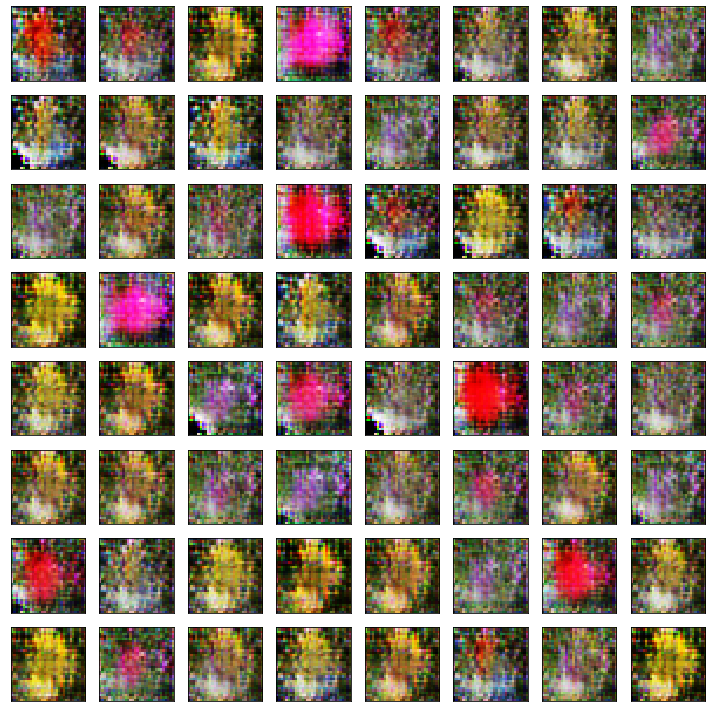


 80%|████████  | 161/200 [2:21:19<42:26, 65.29s/it]

Fri Nov 29 09:24:26 2019 discriminator_loss= 0.0006888668285682797 generator_losss 7.737689



 81%|████████  | 162/200 [2:22:07<38:02, 60.06s/it]

Fri Nov 29 09:25:14 2019 discriminator_loss= 0.000551323422769201 generator_losss 10.436462



 82%|████████▏ | 163/200 [2:22:55<34:45, 56.37s/it]

Fri Nov 29 09:26:02 2019 discriminator_loss= 0.0006399133053491823 generator_losss 8.290426



 82%|████████▏ | 164/200 [2:23:43<32:16, 53.80s/it]

Fri Nov 29 09:26:50 2019 discriminator_loss= 0.0005378197711252142 generator_losss 8.787431



 82%|████████▎ | 165/200 [2:24:30<30:21, 52.03s/it]

Fri Nov 29 09:27:38 2019 discriminator_loss= 0.0005533205221581738 generator_losss 9.927712



 83%|████████▎ | 166/200 [2:25:18<28:47, 50.81s/it]

Fri Nov 29 09:28:26 2019 discriminator_loss= 0.000551705998077523 generator_losss 11.68767



 84%|████████▎ | 167/200 [2:26:06<27:28, 49.95s/it]

Fri Nov 29 09:29:14 2019 discriminator_loss= 0.0006227451522136107 generator_losss 7.16886



 84%|████████▍ | 168/200 [2:26:54<26:17, 49.30s/it]

Fri Nov 29 09:30:01 2019 discriminator_loss= 0.0005895032081753016 generator_losss 10.948445



 84%|████████▍ | 169/200 [2:27:42<25:13, 48.82s/it]

Fri Nov 29 09:30:49 2019 discriminator_loss= 0.0007633308323420351 generator_losss 8.866478
Fri Nov 29 09:31:37 2019 discriminator_loss= 0.0005976697029836942 generator_losss 8.6728325
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

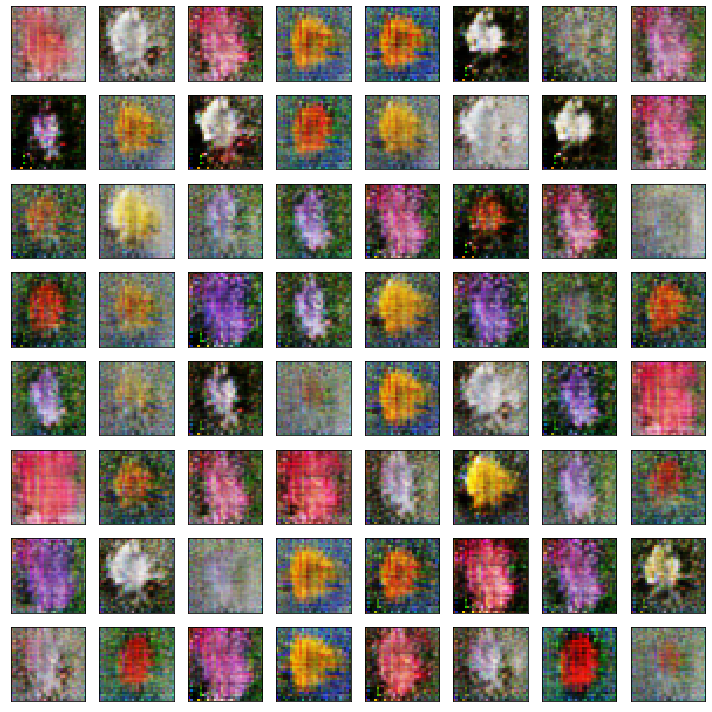


 86%|████████▌ | 171/200 [2:30:40<31:43, 65.62s/it]

Fri Nov 29 09:33:47 2019 discriminator_loss= 0.0005877434305148199 generator_losss 11.404696



 86%|████████▌ | 172/200 [2:31:28<28:09, 60.35s/it]

Fri Nov 29 09:34:35 2019 discriminator_loss= 0.0005645734217978315 generator_losss 8.755071



 86%|████████▋ | 173/200 [2:32:16<25:28, 56.62s/it]

Fri Nov 29 09:35:23 2019 discriminator_loss= 0.0007184069363574963 generator_losss 11.299067



 87%|████████▋ | 174/200 [2:33:04<23:24, 54.01s/it]

Fri Nov 29 09:36:11 2019 discriminator_loss= 0.0005578703357969061 generator_losss 10.2181015



 88%|████████▊ | 175/200 [2:33:52<21:44, 52.19s/it]

Fri Nov 29 09:36:59 2019 discriminator_loss= 0.000537548925876763 generator_losss 11.1853



 88%|████████▊ | 176/200 [2:34:39<20:20, 50.86s/it]

Fri Nov 29 09:37:47 2019 discriminator_loss= 0.000607594427492586 generator_losss 10.536028



 88%|████████▊ | 177/200 [2:35:27<19:09, 49.97s/it]

Fri Nov 29 09:38:35 2019 discriminator_loss= 0.0005291065019719099 generator_losss 9.788172



 89%|████████▉ | 178/200 [2:36:15<18:05, 49.34s/it]

Fri Nov 29 09:39:22 2019 discriminator_loss= 0.0005290608900168081 generator_losss 9.777601



 90%|████████▉ | 179/200 [2:37:03<17:07, 48.92s/it]

Fri Nov 29 09:40:10 2019 discriminator_loss= 0.0005304370197336539 generator_losss 10.397354
Fri Nov 29 09:40:58 2019 discriminator_loss= 0.0005423347001851653 generator_losss 9.744719
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

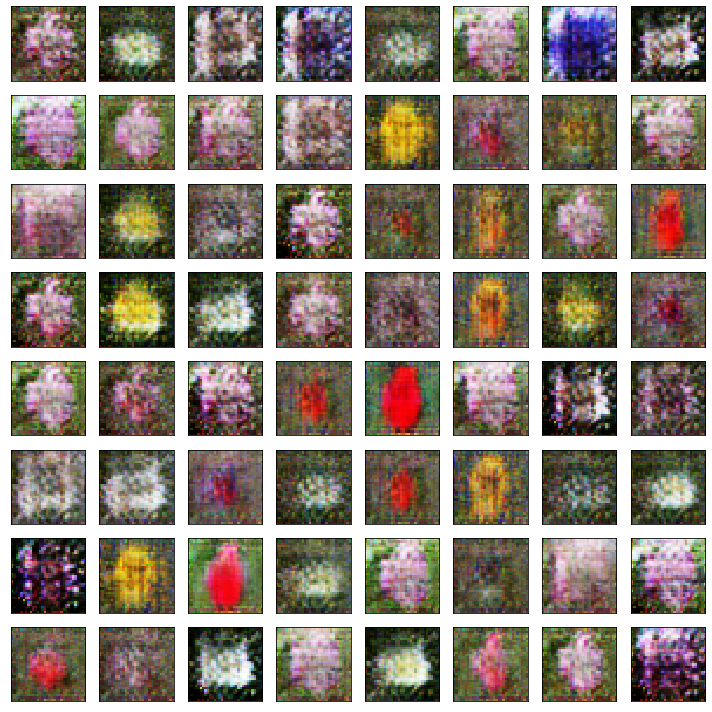


 90%|█████████ | 181/200 [2:40:05<21:02, 66.44s/it]

Fri Nov 29 09:43:12 2019 discriminator_loss= 0.0005322057941157254 generator_losss 10.020167



 91%|█████████ | 182/200 [2:40:53<18:17, 60.95s/it]

Fri Nov 29 09:44:00 2019 discriminator_loss= 0.000746532270568423 generator_losss 12.343362



 92%|█████████▏| 183/200 [2:41:41<16:10, 57.11s/it]

Fri Nov 29 09:44:48 2019 discriminator_loss= 0.0006124826686573215 generator_losss 9.84131



 92%|█████████▏| 184/200 [2:42:29<14:30, 54.43s/it]

Fri Nov 29 09:45:36 2019 discriminator_loss= 0.0005274534146337828 generator_losss 9.658065



 92%|█████████▎| 185/200 [2:43:17<13:07, 52.53s/it]

Fri Nov 29 09:46:24 2019 discriminator_loss= 0.0005735002596338745 generator_losss 11.069325



 93%|█████████▎| 186/200 [2:44:05<11:57, 51.22s/it]

Fri Nov 29 09:47:13 2019 discriminator_loss= 0.0006099015663494356 generator_losss 9.258413



 94%|█████████▎| 187/200 [2:44:53<10:53, 50.28s/it]

Fri Nov 29 09:48:01 2019 discriminator_loss= 0.0007050061103655025 generator_losss 10.091822



 94%|█████████▍| 188/200 [2:45:41<09:55, 49.62s/it]

Fri Nov 29 09:48:49 2019 discriminator_loss= 0.0006563689184986288 generator_losss 7.583723



 94%|█████████▍| 189/200 [2:46:30<09:00, 49.16s/it]

Fri Nov 29 09:49:37 2019 discriminator_loss= 0.17884787172079086 generator_losss 3.9124904
Fri Nov 29 09:50:25 2019 discriminator_loss= 0.02947417600080371 generator_losss 4.296834
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

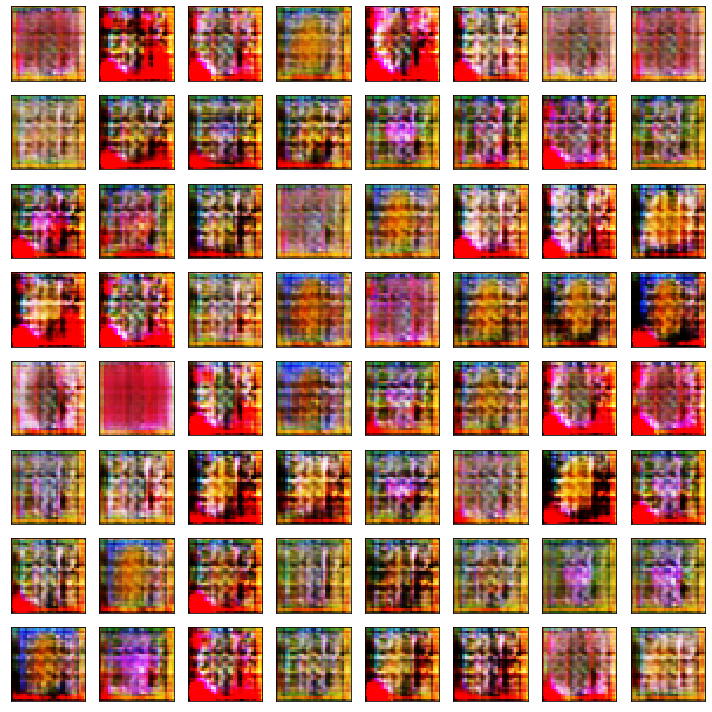


 96%|█████████▌| 191/200 [2:49:35<10:06, 67.39s/it]

Fri Nov 29 09:52:42 2019 discriminator_loss= 0.004356820369139314 generator_losss 1.384635



 96%|█████████▌| 192/200 [2:50:23<08:13, 61.70s/it]

Fri Nov 29 09:53:31 2019 discriminator_loss= 0.0022294431691989303 generator_losss 4.789392



 96%|█████████▋| 193/200 [2:51:12<06:44, 57.72s/it]

Fri Nov 29 09:54:19 2019 discriminator_loss= 0.0007555324846180156 generator_losss 6.307161



 97%|█████████▋| 194/200 [2:52:00<05:29, 54.89s/it]

Fri Nov 29 09:55:07 2019 discriminator_loss= 0.0005605358637694735 generator_losss 8.145126



 98%|█████████▊| 195/200 [2:52:48<04:24, 52.96s/it]

Fri Nov 29 09:55:56 2019 discriminator_loss= 0.0008503246353939176 generator_losss 8.128334



 98%|█████████▊| 196/200 [2:53:37<03:26, 51.55s/it]

Fri Nov 29 09:56:44 2019 discriminator_loss= 0.0007443459762725979 generator_losss 8.086796



 98%|█████████▊| 197/200 [2:54:25<02:31, 50.59s/it]

Fri Nov 29 09:57:32 2019 discriminator_loss= 0.0005916161771892803 generator_losss 7.070461



 99%|█████████▉| 198/200 [2:55:13<01:39, 49.93s/it]

Fri Nov 29 09:58:21 2019 discriminator_loss= 0.0005660773513227468 generator_losss 8.156119



100%|█████████▉| 199/200 [2:56:02<00:49, 49.44s/it]

Fri Nov 29 09:59:09 2019 discriminator_loss= 0.0005707433429051889 generator_losss 8.352066
Fri Nov 29 09:59:57 2019 discriminator_loss= 0.0005885961618332658 generator_losss 9.631474
Saved model to disk
Saved ca to disk
Saved model to disk
Saved model to disk


<Figure size 432x288 with 0 Axes>

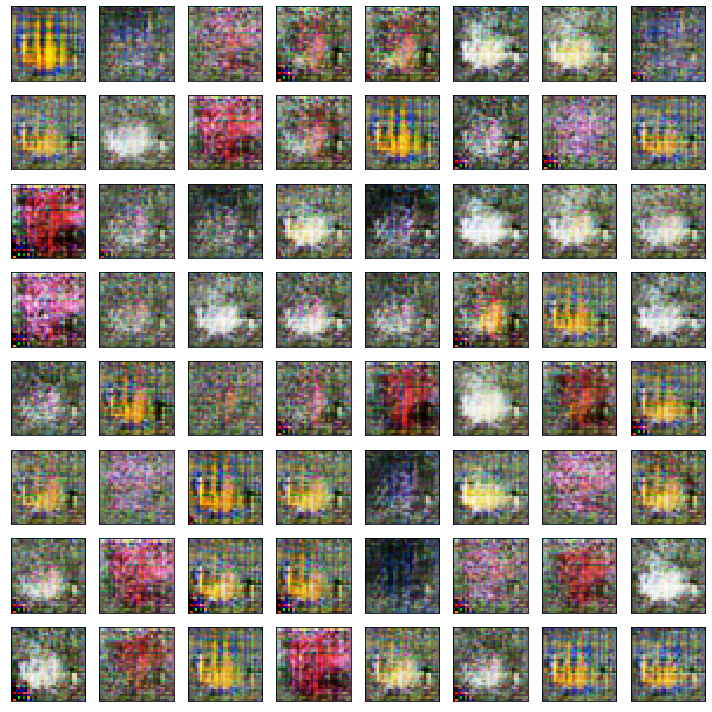


100%|██████████| 200/200 [2:58:22<00:00, 76.78s/it]


In [12]:
gan = Phase1Gan(dataset, kernel=5, strides=2)
gan.compile_gan(False,lr=0.00023)
# gan.update_lr(0.00029)
gan.train(epochs=200, batch_size=100,save=True)

In [0]:
gan = Phase1Gan(dataset, kernel=5, strides=2)
gan.load_models()
samples=64
base = np.random.randint(0,len(dataset.embeddings)-samples)
noise = np.random.normal(loc=0, scale=1, size=(samples, 100))
embeddings = np.asarray([i[0] for i in gan.train_set.embeddings[base:base+samples]])
fake,_ = gan.generator.predict_on_batch([noise,embeddings])
expected = dataset.images[base:base+samples]
# fake=expected
plt.clf()
fig = plt.figure(figsize=(10,10))
for i in range(samples):
    sub = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    im = fake[i]
    im = (im + 1.0) * 127.5
    im = im.astype(np.uint8)
    # Image.fromarray(np.asarray(im)).show()
    plt.imshow(im)
    # sub.imshow(((fake[i]+1)*127).astype(np.uint8))
fig.tight_layout()
plt.show()